# Assignment 2: *Breath of the Wild* analysis

**DTU - Social Graphs & Interactions**

**Instructions:** [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) 

**Due date and time**: The assignment is due on **Tuesday November the 2nd, 2021** at 23:59. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/

---

### Overview

This year's Assignment 2 is all about analyzing the network of The Legend of Zelda: Breath of the Wild.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

## Table of Contents:
- [__Part 0: Building the network__](#0.)


- [__Part 1: Network visualization and basic stats__](#1.)

    - [1.a <u>Stats</u>](#1.a.)
    - [1.b <u>Visualisation</u>](#1.b.)


- [__Part 2: Word-clouds__](#2.)


- [__Part 3: Communities and TF-IDF__](#3.)

    - [3.a <u>Finding communities</u>](#3.a.)
    - [3.b <u>Computing TF-IDF</u>](#3.b.)


- [__Part 4: Sentiment of communities__](#4.)
---

<a id='0.'></a>
# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

**Question: Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.**

**[ OUR ANSWER ]**

To extract hyperlinks from the collected Wiki-pages, we processed as follows for each character:

- We read the associated collected text file
- We apply 3 different regex successively to extract hyperlinks (more details in following question)
- We remove loops i.e. characters which refer to themselves

![hyperlinks extraction explanation figure](https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/pictures%20for%20notebook/Explain%20hyperlinks%20extraction.jpg)

**Question: Show the regular expression(s) you have built and explain in details how it works.**

**[ OUR ANSWER ]**

**Pattern 1 : extract hyperlinks with double brackets [[ . ]]**

`pattern1 = "\[\[(.*?)(?:#.*?)?(?:\(.*?)?(?:\|.*?)?\]\]"`

With this `pattern1`, we can extract following hyperlinks formats: `[[name of character]]` (direct links), `[[name of character|blabla]]`  (links using text), `[[name of character (blabla)]]` (links using parentheses), `[[name of character#Breath of the Wild]]` (links with sections).

Let's detail how `pattern1` works:
- `'\[\['` matches the opening double square backets '[[' 
- `.*?` with the . matches any character except from the new line \n, with .*? change it to be non-greedy
- `(?:#.*?)?` with ? match 0 or 1 occurrences of the pattern to its left, the # matches the character #, the rest as before with the : you choose one of the both parts 
-  `(?:\(.*?)?` with ? match 0 or 1 occurrences of the pattern to its left, then matches the context in the parenthesis at the end with the ? 0 or 1 occurence to its left
- `(?:\|.*?)?` as before the ? match 0 or 1 occurrence of the pattern to its left, then matches the | character the following part is repeated
- the last two `\[\[` is to identify the double square brackets

**Pattern 2 & 2bis : extract hyperlinks with double braces {{ . }}**

`pattern2 = "\{\{(?:Term|Plural)\|BotW\|(.*?)\}\}"`

With this `pattern2`, we can extract following hyperlinks formats: `{{Term|BotW|name of character|link}}` (direct links), `{{Term|Series|name of character|link|display=Zelda}}`  (links using text), `{{Term|Series|Ocarina of Time (Item)|link}}` (links using parentheses), `{{Plural|Series|name of character|link}}` (links using plural), `{{Term|BotW|name of character|link}}` (links with sections).

The format of this regex is a bit different from the previous one, at the beginning as before we need to find the double curly brackets followed by from the string `Term|Plural)\|BotW` seperated by | to remove this part. Then we get anyhting with the .*, the whole string ends with the double curly brackets once again which we do not need to capture.

However, after applying this second pattern, some of the strings have the format `name of character|link|display=Zelda`. In order to remove the unnecessary words, we use the `pattern2bis` on each element extracted by the `pattern2`. 

`pattern2bis = "(.*?)(?:#.*?)?(?:\(.*?)?(?:\|.*?)"`

Let's detail how `pattern2bis` works:
- `.*?` captures everything at the beggining
- `(?:#.*?)?` 0 or 1 occurances to its left and capture if exists a string after the #
- `(?:\(.*?)?` 0 or 1 occurances to its left then not capture anything inside the parenthesis
- `(?:\|.*?)` 0 or 1 occurances to its left then not capture the | if exist. At the end capture whatever exists

<a id='1.'></a>
# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

First, let's import the CSV we generated during work sessions on BotW, with all characters, and their race/role/gender/relations (i.e. characters they refer to).

In [22]:
# import packages for Part 1
import pandas as pd ; import networkx as nx ; import ast ; import matplotlib.pyplot as plt ; import numpy as np

In [3]:
# import csv with characters
df_characters = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/botw_dataframe_with_relations.csv")

# replace Cherry by Ancient Oven (tips from Week 6)
index_Cherry = int(df_characters[df_characters.Name=='Cherry'].index.to_list()[0])
df_characters.loc[index_Cherry, 'Name']='Ancient_Oven'

Then we can build our network based on our characters database.

In [8]:
def add_node(row, aGraph):
    """ Add the node given in row to global network """
    aGraph.add_node(row.Name, gender=row.Gender, race=row.Race, role=row.Role)

def add_edges(row, aGraph):
    """ Add all edges which concern given character in row"""
    char_name = row.Name
    char_relations = ast.literal_eval(row.Relations)
    for aTargetRelation in char_relations:
        aGraph.add_edge(char_name,aTargetRelation)

# Create the whole graph with all node attributes : role, race, genre    
G = nx.DiGraph()
_ = df_characters.apply(add_node, args=(G,), axis=1)
_ = df_characters.apply(add_edges, args=(G,), axis=1)

# Extract the Giant Connected Component
all_components = list(nx.weakly_connected_components(G))
all_components.sort(key=len)
GCC = all_components[-1]
G = G.subgraph(GCC).copy()

# Make our graph undirected
GU = G.to_undirected()

<a id='1.a.'></a>
## Exercise 1a: Stats

##### What is the number of nodes in the network?

In [9]:
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 515


##### What is the number of edges in the network?

In [10]:
print('Number of edges:', G.number_of_edges())

Number of edges: 1534


##### Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [11]:
def display_degree_types_ranking(aDirectedGraph, rank, conditionFunction=None):
    """ Print a ranking of top-connected nodes in a given directed graph """
    all_degrees_dicts = {'in': dict(aDirectedGraph.in_degree), 'out':dict(aDirectedGraph.out_degree)}
    for type_name, all_degrees in all_degrees_dicts.items():
        top_connected_char = sorted(all_degrees.items(), reverse = True, key=lambda item: item[1])
        print(f"For {type_name}-degrees, the {rank}-top connected characters is: ")
        count = 0
        for aName, aDegree in top_connected_char:
            if count >= rank:
                break
            if (conditionFunction == None) or (conditionFunction(aName, aDirectedGraph)):
                print(f"-> {aName} with {aDegree} links")
                count += 1
        print('\n')

display_degree_types_ranking(G, 1)


For in-degrees, the 1-top connected characters is: 
-> Link with 370 links


For out-degrees, the 1-top connected characters is: 
-> Traysi with 14 links




**[ OUR ANSWER ]**

It makes sense to find Link as the top connected character for in-degrees: it means that many characters refer to Link in their description. Indeed, Link is the hero of *Breath of the Wild* which is played by the Ninendo Switch player. Through his quests, Link interacts with various characters and this interaction should be explained in each character's description.

About Traysi found as the top connected character for out-degrees, we learn in her description that she's an "investigative journalist". Thus it's also quite consistent that she is the character which refers the most to other characters. Indeed, her description details all her investigation missions.

<p align="center">
  <img alt="BotW screenshot, Link and Traysi" src="https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/pictures%20for%20notebook/Link%20and%20Traysi%20top%20connected.jpg">
  Screenshot of Link and Traysi in the Breath of the Wild
</p>

##### Who are the top 5 most connected allies (again in terms of in/out-degree)?

In [12]:
def conditionAlly(aName, aGraph):
    return dict(aGraph.nodes(data=True))[aName]['role'] == 'Ally'

print("ALLIES ONLY\n")
display_degree_types_ranking(G, 5, conditionAlly)

ALLIES ONLY

For in-degrees, the 5-top connected characters is: 
-> Link with 370 links
-> Hylia with 67 links
-> Princess Zelda with 24 links
-> Riju with 23 links
-> Purah with 16 links


For out-degrees, the 5-top connected characters is: 
-> Traysi with 14 links
-> Daruk with 10 links
-> Banji with 9 links
-> Link with 9 links
-> Urbosa with 9 links




##### Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [13]:
def conditionNotAlly(aName, aGraph):
    return dict(aGraph.nodes(data=True))[aName]['role'] != 'Ally'

print("ENNEMIES & BOSSES ONLY\n")
display_degree_types_ranking(G, 5, conditionNotAlly)

ENNEMIES & BOSSES ONLY

For in-degrees, the 5-top connected characters is: 
-> Calamity Ganon with 97 links
-> Bokoblin with 18 links
-> Lizalfos with 9 links
-> Stalizalfos with 8 links
-> Stone Talus with 8 links


For out-degrees, the 5-top connected characters is: 
-> Stalizalfos with 12 links
-> Lizalfos with 11 links
-> Silver Lizalfos with 11 links
-> Moblin with 10 links
-> Blue Lizalfos with 9 links




##### Plot the in- and out-degree distributions.

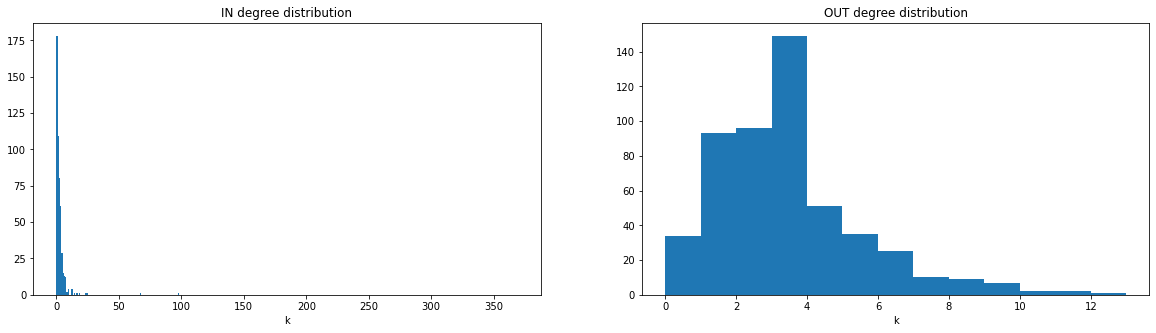

In [16]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title("IN degree distribution")
plt.xlabel("k")
plt.hist(list(dict(G.in_degree()).values()),bins=range(max(list(dict(G.in_degree()).values()))-min(list(dict(G.in_degree()).values()))))

plt.subplot(122)
plt.title("OUT degree distribution")
plt.xlabel("k")
plt.hist(list(dict(G.out_degree()).values()), bins=range(max(list(dict(G.out_degree()).values()))-min(list(dict(G.out_degree()).values()))))

plt.show()

##### What do you observe?

**[ OUR ANSWER ]**

TO ANSWER

##### Can you explain why the in-degree distribution is different from the out-degree distribution?

**[ OUR ANSWER ]**

In and out degree distributions are different because when a character X page links to another character Y, we are not likely to find the back link to X in character Y page.

##### Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. What does it say about our network?

In [18]:
# in and out degree exponents computation, using powerlaw.Fit (Week 5)
import powerlaw
indegree_exponent, outdegree_exponent = powerlaw.Fit(list(dict(G.in_degree()).values())).alpha, powerlaw.Fit(list(dict(G.out_degree()).values())).alpha

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Laurine\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [19]:
print("The exponent of the in-degree distribution is {}.".format(round(indegree_exponent,3)))
print("The exponent of the out-degree distribution is {}.".format(round(outdegree_exponent,3)))

The exponent of the in-degree distribution is 3.043.
The exponent of the out-degree distribution is 4.526.


**[ OUR ANSWER]**

We note that `in-degree exponent < out-degree exponent`. Thus, nodes are more likely to point toward other ones, than be pointed. It confirms what we oberved previously from distributions analysis.

##### Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.

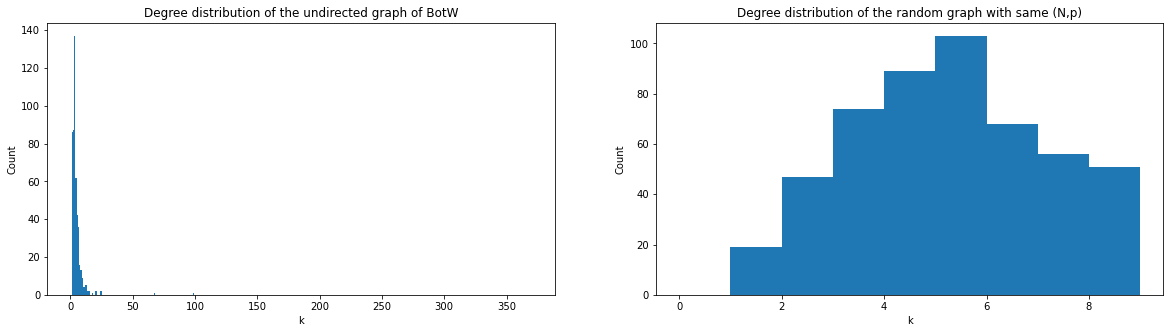

In [20]:
# random graph generation, with the same number of nodes and the same probablity of connection 
random_graph = nx.gnm_random_graph(n=int(GU.number_of_nodes()), m=int(GU.number_of_edges()))

# plot degree distributions
plt.figure(figsize=(20,5))

# plot undirected graph case
plt.subplot(121)
plt.title('Degree distribution of the undirected graph of BotW')
plt.xlabel('k')
plt.ylabel('Count')
plt.hist(list(dict(GU.degree()).values()), bins=range(max(list(dict(GU.degree()).values()))-min(list(dict(GU.degree()).values()))))

# plot random graph case
plt.subplot(122)
plt.title('Degree distribution of the random graph with same (N,p)')
plt.xlabel('k')
plt.ylabel('Count')
plt.hist(list(dict(random_graph.degree()).values()), bins=range(max(list(dict(random_graph.degree()).values()))-min(list(dict(random_graph.degree()).values()))))

plt.show()

**[ OUR ANSWER]**

TO ANSWER : comparison

<a id='1.b.'></a>
## Exercise 1b: Vizualisation

##### Create a nice visualization of the total (undirected) network

In [23]:
# set node color and size 
get_color = {'Ally':'green','Enemy':'red','Boss':'purple'}

colors_list, size_list = [], []
for nodeName, nodeAttributes in list(GU.nodes(data=True)):
    # color nodes according to the role
    colors_list.append(get_color[nodeAttributes['role']])
    # scale node-size according to degree
    size_list.append(GU.degree(nodeName))

size_list = list(20*np.array(size_list))

In [24]:
# optional: set edge color according to the role
edge_colors_list = []
for source, target in list(GU.edges()):
    edgeColor = 'blue'
    if GU.nodes[source]['role']=='Ally' and GU.nodes[target]['role']=='Ally':
        edgeColor = 'orange'
    if GU.nodes[source]['role']!='Ally' and GU.nodes[target]['role']!='Ally':
        edgeColor = 'brown'
    edge_colors_list.append(edgeColor)

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.52it/s]


BarnesHut Approximation  took  1.51  seconds
Repulsion forces  took  8.52  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


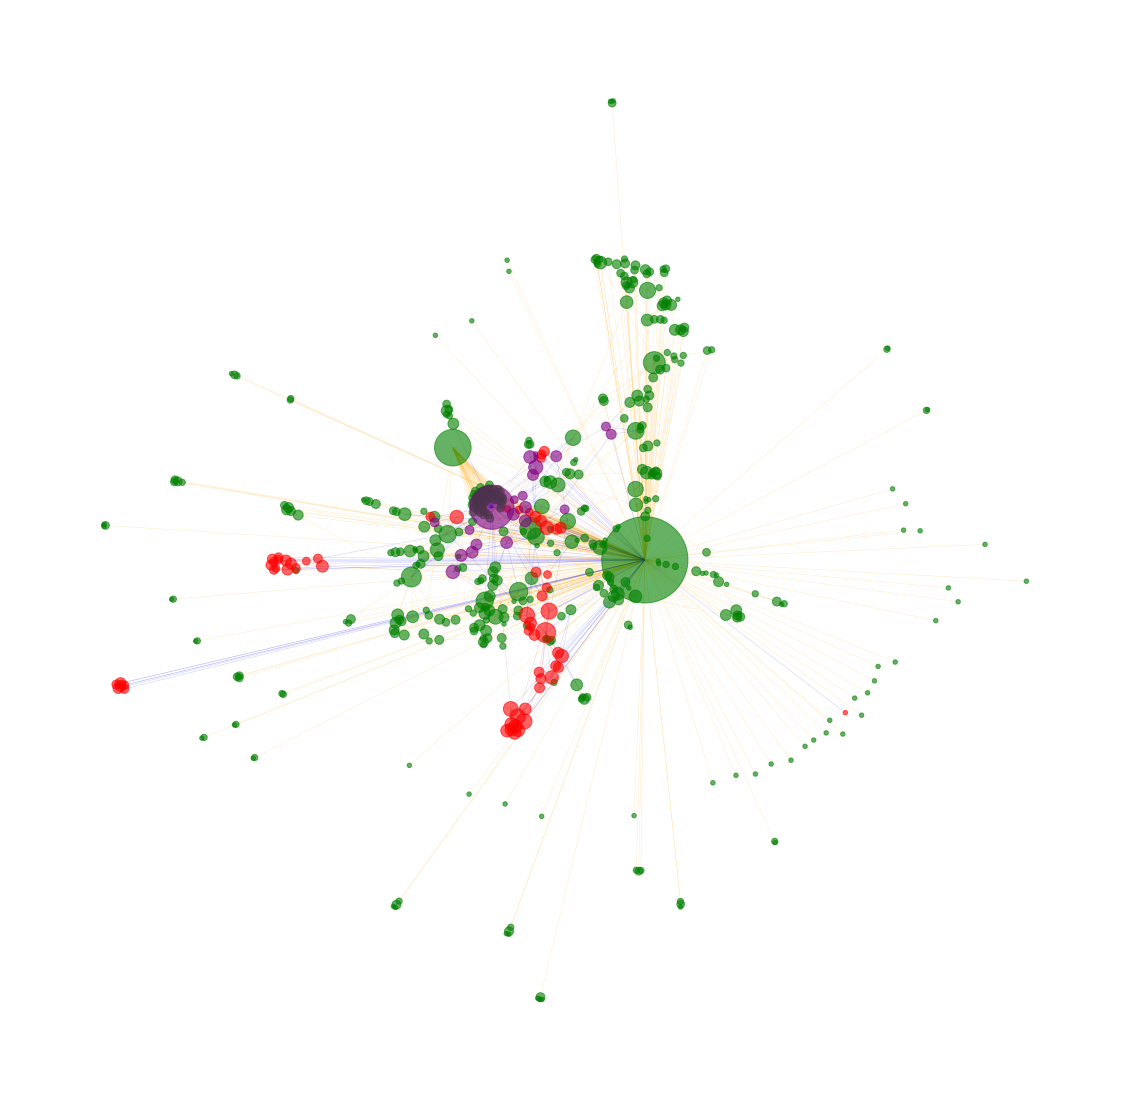

In [26]:
# Force Atlas 2 algorithm configuration
import fa2
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

# get node positions from force atlas
pos = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=1000)

# plot network
fig, ax = plt.subplots(figsize=(20, 20))

nx.draw_networkx_nodes(GU,pos=pos, node_color=colors_list, node_size=size_list, alpha=0.6)
nx.draw_networkx_edges(GU,pos=pos, edge_color=edge_colors_list, width=0.5, alpha=0.2)

plt.axis('off')
plt.show()

##### Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

**[ OUR ANSWER ]**

From the graph it is clear that some of the Allies (green colour) are in the most privilleged position, then the Bosses (purple colour) and finally the Enemies (red colour) based on the degree of the nodes. There are some chains of connected nodes between different roles if you notice the arround the biggest Boss node. It can be noticed that most of the enemies are connected to the biggest Allies. 

<a id='2.'></a>
# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [37]:
# import packages for Part 2
import nltk ; from wordcloud import WordCloud, ImageColorGenerator ; from PIL import Image ; import urllib.request

In [38]:
# load the dataset of clean tokens list per each character
url_tokens_per_character = 'https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/botw_dataframe_tokens.csv'
df_tokens = pd.read_csv(url_tokens_per_character)

In [39]:
# create races_documents, the dictionary of {race:NLTK Text object}
def get_concatenated_tokens(aListOfCharacters):
    """ Get the merged list of tokens of a given list of characters (based on df_tokens reference) """
    all_tokens = []
    for aCharacter in aListOfCharacters:
        all_tokens += list(df_tokens[df_tokens.Name == aCharacter].Tokens)[0].split(' ')
    return [ aToken for aToken in all_tokens if aToken != '']

races_to_plot = ['Hylian', 'Zora', 'Goron', 'Gerudo', 'Rito']

races_documents = {}
for aRace in races_to_plot:
    race_text = get_concatenated_tokens(list(df_characters[df_characters.Race == aRace].Name))
    races_documents[aRace] = nltk.Text(race_text)

In [40]:
# create races_TC_IDF
url_races_TC_IDF = "https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/races_TC_IDF_sorted.txt"
races_TC_IDF = ast.literal_eval(urllib.request.urlopen(url_races_TC_IDF).read().decode("utf-8"))

In [41]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [42]:
# get masks for plots
url_base_masks = "https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/masks/"
all_masks = ["hylian.jpg", "zora.PNG", "goron.PNG", "gerudo.png", 'rito.png']
all_masks = [ urllib.request.urlopen(url_base_masks+aMaskFileName) for aMaskFileName in all_masks ]

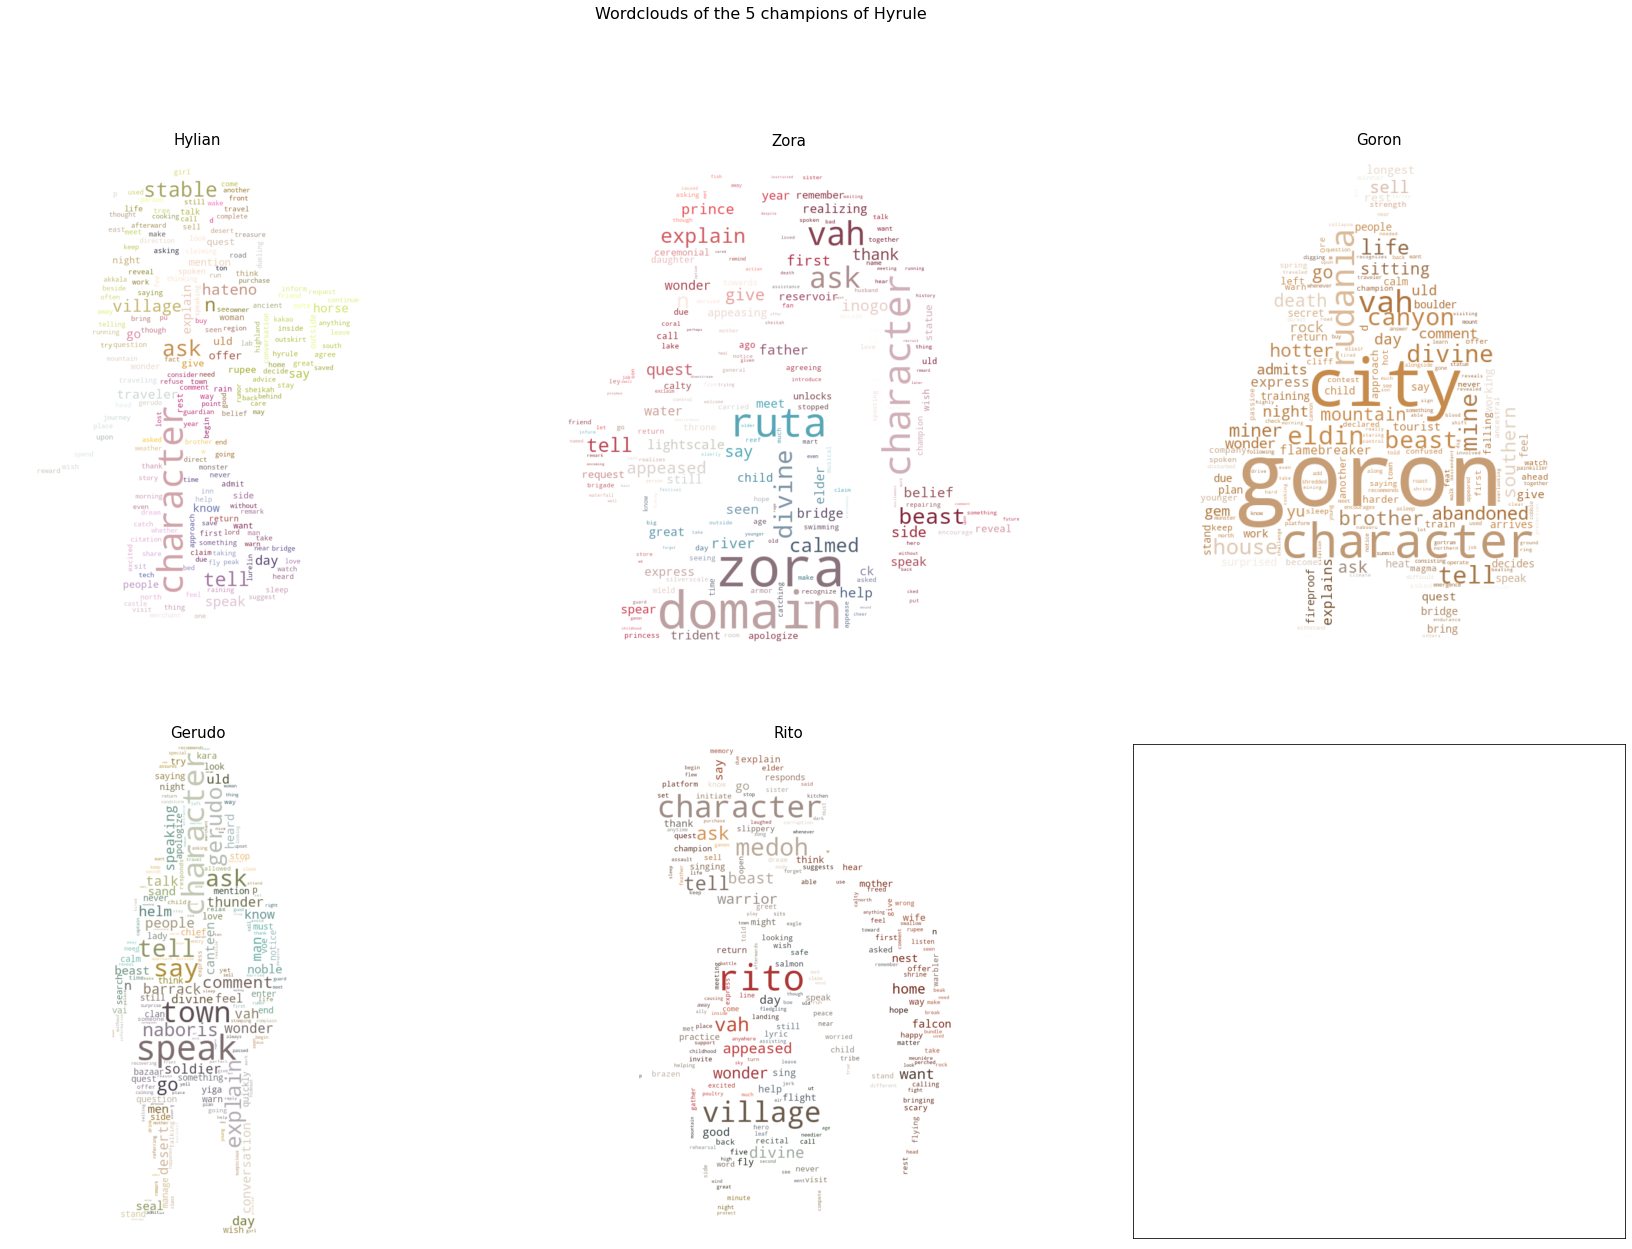

In [43]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the 5 champions of Hyrule", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<len(races_to_plot):
        plot_wordcloud(races_to_plot[i], races_documents, races_TC_IDF, all_masks[i], ax)

plt.show()

<a id='3.'></a>
# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

<a id='3.a.'></a>
## 3a. Finding communities

##### Explain the Louvain algorithm and how it finds communities in a newtork.

**[ OUR ANSWER ]**

The Louvain algorithm is a method based on modularity to split a network into connected communities.  The goal is to maximize the modularity of a given partition, comparing edge densitiy inside and outside defined communities. In the process of this algorithm, we start by finding small communities through modularity local optimization. Then the nodes of each communities are gathered into a unique node per community, and we apply the previous step again.

##### Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 

**[ OUR ANSWER ]**

We tested several partitions, based on race, role, gender and using Louvain-algorithm. The best result can be obtained with this last method, so we call the Python Louvain-algorithm implementation here.

**Let's proceed to the Louvain partition on our network.**

In [44]:
from community import community_louvain

best_partition = community_louvain.best_partition(GU)

def get_partition(attribute, aGraph):
    """ Return a partition of aGraph based on given attribute as a dictionary of community subgraphs """
    nodes_attributes_dic = {k:v[attribute] for k,v in dict(G.nodes(data=True)).items()}
    return get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph)

def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

def get_modularity(communities_dic, aGraph):
    """ Get the modularity M of the partition of a graph aGraph given through the dictionary of subgraphs communities_dic """
    L = aGraph.number_of_edges()
    M = 0
    for _, aCommunityGraph in communities_dic.items():
        Lc = aCommunityGraph.number_of_edges()
        kc = sum(list(dict(aCommunityGraph.degree).values()))
        M += (Lc/L - (kc/(2*L))**2)
    print("Modularity M = {}".format(round(M, 2)))
    return M

best_partition_subgraphs = get_partition_from_nodes_attributes(best_partition, G)

**How many communities did you find in total?**

In [45]:
print(f"The partition based on Louvain-algorithm detects {len(list(best_partition_subgraphs.keys()))} communities.")

The partition based on Louvain-algorithm detects 19 communities.


**Compute the value of modularity with the partition created by the algorithm.**

In [46]:
print("For the partition based best partition with Louvain-algorithm:")
best_partition_modularity = get_modularity(best_partition_subgraphs, G)

For the partition based best partition with Louvain-algorithm:
Modularity M = 0.68


**Plot the distribution of community sizes.**

In [47]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in best_partition_subgraphs.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

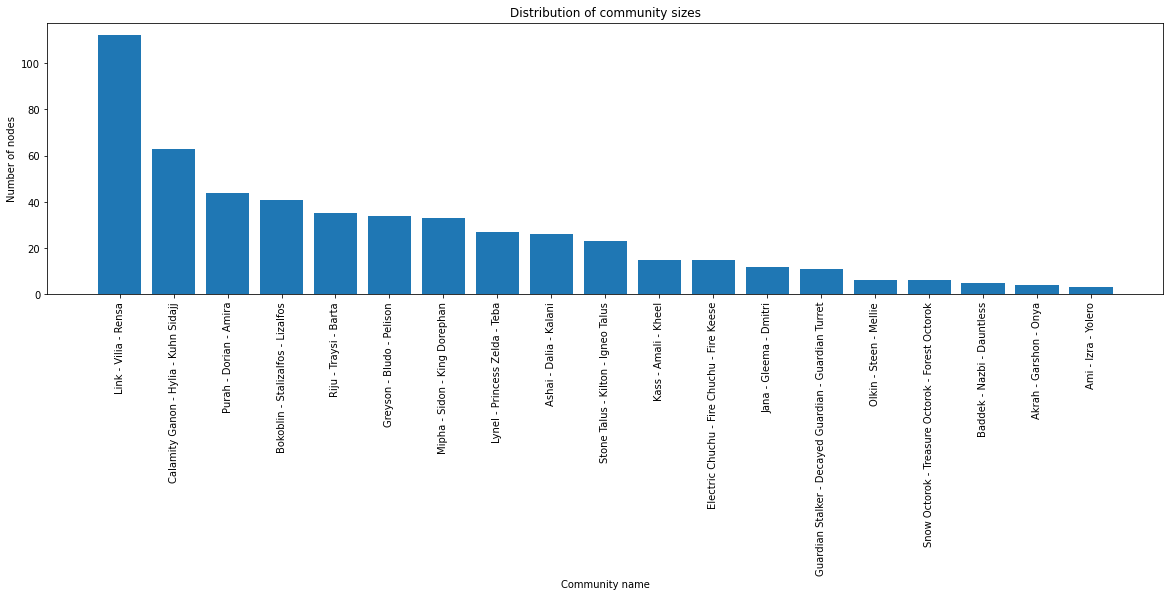

In [48]:
from collections import Counter

# get the size of each community
best_partition_counter = dict(Counter(list(best_partition.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))

# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values())
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes")
plt.show()

<a id = '3.b.'></a>
## 3b. Computing TF-IDF

##### For the 5 largest communities, create TF-IDF based rankings of words in each community.

In [49]:
# find the 5 largest communities

largest_communities_ids = list(best_partition_counter.keys())[:5]

print("The 5 largest communities from our Louvain-algorithm parition are:")
for aIdCommunity in largest_communities_ids:
    print("- Community named '{}' with {} nodes".format(communities_names[aIdCommunity], best_partition_counter[aIdCommunity]))

The 5 largest communities from our Louvain-algorithm parition are:
- Community named 'Link - Vilia - Rensa' with 112 nodes
- Community named 'Calamity Ganon - Hylia - Kuhn Sidajj' with 63 nodes
- Community named 'Purah - Dorian - Amira' with 44 nodes
- Community named 'Bokoblin - Stalizalfos - Lizalfos' with 41 nodes
- Community named 'Riju - Traysi - Barta' with 35 nodes


##### There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.

**[ OUR ANSWER ]**

To calculate our TF-IDF for the 5 largest communities, we processed as follows:
1. For each character, get the list of representative tokens from the description of Wiki page by: 
    - removing header sections
    - applying lower case
    - removing plural versions of characters
    - applying tokenization
    - applying lemmatization
    - removing doubles (each token is unique for each character's list)
2. We create one text per community, by concatenating the tokens of concerned characters.
3. Compute TF [Term Frequecy] using the frequency distributions of each community text generated by NLTK module.
4. Compute IDF [Inverse Document Frequency].
5. Compute TF*IDF.

>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

Let's create one text per community, by concatenating the tokens of concerned characters.

In [50]:
# create one text for each of the 5 largest communities we found previously only

community_texts = {}
for anId in largest_communities_ids:
    aSubgraph = best_partition_subgraphs[anId]
    community_text = get_concatenated_tokens(list(aSubgraph.nodes()))
    community_texts[anId] = nltk.Text(community_text)

We compute TF.

In [51]:
# first, we compute the frequency distribution of each community text, and store them in a dictionary
community_fdist = {aCommunity:nltk.FreqDist(aText) for aCommunity, aText in community_texts.items()}

def getTF(t, aFdist):
    """ Get the term frequency of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist.freq(t)

**List the 5 top words for each community according to TF.**

In [53]:
def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each community 
community_top_5_terms = {aCommunity:find_top_5_terms(aCommunityText) for aCommunity, aCommunityText in community_texts.items()}

# print results
print("The top 5 terms for each community is:\n")
for aCommunity, aListOfTerms in community_top_5_terms.items():
    print("- Community named '{}' : {}".format(communities_names[aCommunity], list(aListOfTerms.keys())))

The top 5 terms for each community is:

- Community named 'Link - Vilia - Rensa' : ['character', 'breath', 'wild', 'tell', 'also']
- Community named 'Calamity Ganon - Hylia - Kuhn Sidajj' : ['year', 'great', 'away', 'n', 'goddess']
- Community named 'Purah - Dorian - Amira' : ['character', 'breath', 'wild', 'village', 'first']
- Community named 'Bokoblin - Stalizalfos - Lizalfos' : ['breath', 'wild', 'found', 'legend', 'enemy']
- Community named 'Riju - Traysi - Barta' : ['breath', 'wild', 'gerudo', 'character', 'town']


**List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.**

In [54]:
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTF(t,fdist_dic[aCommunity]) else 0 for aCommunity in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words = list(set([item for sublist in df_tokens.Tokens for item in sublist.split(' ')]))
all_words = [aWord for aWord in all_words if aWord != '']
all_words_IDFs = {aTerm:getIDF(aTerm, community_texts, community_fdist) for aTerm in all_words}

In [56]:
def getTF_IDF(t,aFdist):
    """ get the TF*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTF(t, aFdist) * all_words_IDFs[t]

communities_TF_IDF = {aCommunity:{aTerm:getTF_IDF(aTerm, community_fdist[aCommunity]) for aTerm in aText } for aCommunity,aText in community_texts.items() }
# sort TF-IDF result
communities_TF_IDF_sorted = {aCommunity:dict(sorted(aTFIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aCommunity, aTFIDF_dic in communities_TF_IDF.items()}

# print results
print("The top 5 terms based on TF*IDF for each community is:\n")
for aCommunity, aTF_IDF_dic in communities_TF_IDF_sorted.items():
    print("- Community named '{}' : {}".format(communities_names[aCommunity], list(aTF_IDF_dic)[:5] ))

The top 5 terms based on TF*IDF for each community is:

- Community named 'Link - Vilia - Rensa' : ['clothes', '20', 'cooking', 'dueling', 'peak']
- Community named 'Calamity Ganon - Hylia - Kuhn Sidajj' : ['ostracism', 'monk', 'entered', 'greeted', 'constructed']
- Community named 'Purah - Dorian - Amira' : ['fountain', 'hateno', 'rain', 'describe', 'shift']
- Community named 'Bokoblin - Stalizalfos - Lizalfos' : ['variant', 'stronger', 'stlfos', 'horn', 'stal']
- Community named 'Riju - Traysi - Barta' : ['barrack', 'recovering', 'chief', 'blame', 'captain']


**ANSWER THE QUESTION HERE : INTERPRETATION !!!!!**

<a id='4.'></a>
# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

First, we need to import the JSON file of characters dialogues from Social Graph GitHub.

In [58]:
# import characters dialogues
import json
url_characters_dialogue = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/CharactersDialogue.json'
content_characters_dialogue = urllib.request.urlopen(url_characters_dialogue).read().decode('utf-8')
characters_dialogue = json.loads(content_characters_dialogue)

We also need to import LabMT dataset. We decided to turn it into a dictionary `LabMT_dict = {word:happiness_average}` that we can use later in analysis.

In [60]:
# load LabMT dataset
url_LabMT = "https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Assignment%202/dataset_LabMT"
LabMT = urllib.request.urlopen(url_LabMT).read().decode('utf-8')
# remove the useless start of the text
LabMT = LabMT[172:]
# process text file for dictionary conversion
LabMT = LabMT.split('\n')
LabMT = [aList.split('\t') for aList in LabMT]
# create LabMT dictionary
LabMT_dict = {}
for aList in LabMT:
    if len(aList) == 8:
        aWord = aList[0]
        # we only take "happiness_average" in account here
        aHappinessAvg = float(aList[2])
        LabMT_dict[aWord]=aHappinessAvg

**Calculate and store sentiment for every character**

For LabMT method, we create three useful functions:
- `get_list_of_tokens` to transform a sentence into a list of tokens
- `get_happiness_average` to get the happiness average of a word from LabMT dictionary
- `calculate_LabMT_sentiment` to get the LabMT sentiment score of a list of tokens

In [63]:
from nltk.tokenize import RegexpTokenizer

def get_list_of_tokens(aSentence):
    """ Transform a sentence (string) into a list of tokens """
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def get_happiness_average(aWord):
    """ Get the happiness average of a word from LabMT dictionary """
    if aWord in list(LabMT_dict.keys()) :
        return LabMT_dict[aWord]
    return None

def calculate_LabMT_sentiment(aListOfTokens):
    """ Calculate the sentiment score of a list of tokens """
    sentiment_score = 0
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            anHapinessAvg = get_happiness_average(aToken)
            if anHapinessAvg != None:
                sentiment_score += anHapinessAvg
        return sentiment_score/len(aListOfTokens)
    return sentiment_score

In [64]:
# calculate the sentiment LabMT score for each character

sentiment_LabMT_score_list = []

def calculate_LabMT_sentiment_of_a_node(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        sentiment_LabMT_score_list.append(np.mean([calculate_LabMT_sentiment(get_list_of_tokens(aSentence)) for aSentence in characters_dialogue[aRow.Name]]))
    else:
        sentiment_LabMT_score_list.append(None)

_ = df_characters.apply(calculate_LabMT_sentiment_of_a_node, axis=1)

In [65]:
# store in dataframe of characters as a new column
df_characters['LabMT_score']=sentiment_LabMT_score_list
df_LabMT = df_characters[df_characters.LabMT_score.notnull()]

For VADER method,

In [66]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [67]:
analyzer = SentimentIntensityAnalyzer()

vader_score_list = []

def calculate_VADER_of_a_node(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        vader_score_list.append(np.mean([analyzer.polarity_scores(aSentence)['compound'] for aSentence in characters_dialogue[aRow.Name]]))
    else:
        vader_score_list.append(None)

_ = df_characters.apply(calculate_VADER_of_a_node, axis=1)

In [68]:
df_characters['VADER_score']=vader_score_list
df_VADER = df_characters[df_characters.VADER_score.notnull()]

**Create a histogram of all character's associated sentiments.**

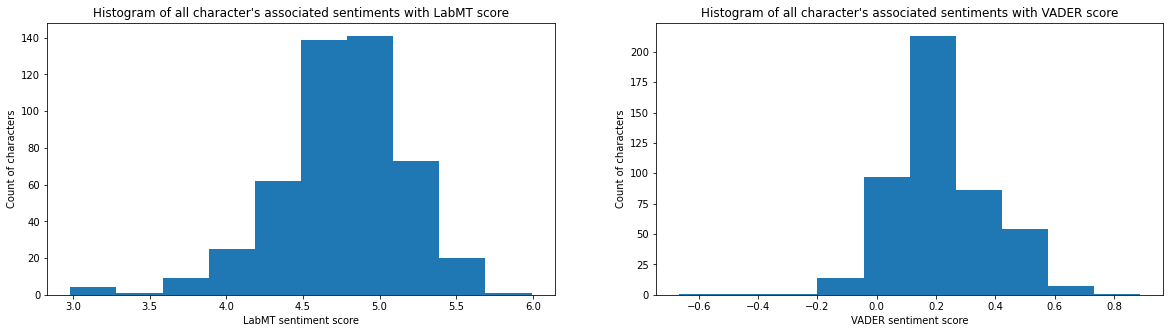

In [69]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.hist(df_LabMT.LabMT_score)
plt.title("Histogram of all character's associated sentiments with LabMT score")
plt.xlabel("LabMT sentiment score")
plt.ylabel("Count of characters")

plt.subplot(122)
plt.hist(df_VADER.VADER_score)
plt.title("Histogram of all character's associated sentiments with VADER score")
plt.xlabel("VADER sentiment score")
plt.ylabel("Count of characters")
plt.show()

**What are the 10 characters with happiest and saddest pages?**

In [70]:
def print_characters_with_score(a10DataFrame, typeOfScore):
    i=1
    for index, row in a10DataFrame.iterrows():
        print("{}. {} ({})".format(i, row.Name, round(row[typeOfScore],2)))
        i+=1

In [71]:
ten_happiest_characters_LabMT = df_LabMT.sort_values('LabMT_score', ascending=False).head(10)
ten_saddest_characters_LabMT = df_LabMT.sort_values('LabMT_score', ascending=True).head(10)

ten_happiest_characters_VADER = df_VADER.sort_values('VADER_score', ascending=False).head(10)
ten_saddest_characters_VADER = df_VADER.sort_values('VADER_score', ascending=True).head(10)

print("10 happiest characters with LabMT method are:")
print_characters_with_score(ten_happiest_characters_LabMT, 'LabMT_score' )
print("\n10 happiest characters with VADER method are:")
print_characters_with_score(ten_happiest_characters_VADER, 'VADER_score' )
print("\n10 saddest characters with LabMT method are:")
print_characters_with_score(ten_saddest_characters_LabMT, 'LabMT_score')
print("\n10 saddest characters with VADER method are:")
print_characters_with_score(ten_saddest_characters_VADER, 'VADER_score')

10 happiest characters with LabMT method are:
1. Tasho (5.99)
2. Katta (5.69)
3. Kish (5.66)
4. Ozunda (5.66)
5. Padok (5.66)
6. Toren (5.63)
7. Oaki (5.59)
8. Piaffe (5.58)
9. Damia (5.58)
10. Zyle (5.53)

10 happiest characters with VADER method are:
1. Zooki (0.89)
2. Breen (0.71)
3. Canni (0.71)
4. Toren (0.65)
5. Peeks (0.63)
6. Harlow (0.63)
7. Zyle (0.61)
8. Nazbi (0.6)
9. Sebasto (0.57)
10. Kula (0.57)

10 saddest characters with LabMT method are:
1. Haite (2.98)
2. Olu (3.13)
3. Kampo (3.18)
4. Yunobo (3.19)
5. Dugby (3.44)
6. Konora (3.62)
7. Kinov (3.7)
8. Tona (3.73)
9. Walton (3.77)
10. Ledo (3.78)

10 saddest characters with VADER method are:
1. Palme (-0.67)
2. Kotta (-0.47)
3. Princess Zelda (-0.35)
4. Sumati (-0.16)
5. Monkton (-0.15)
6. Flaxel (-0.15)
7. Master Kohga (-0.13)
8. Kotts (-0.12)
9. Strade (-0.11)
10. Rik (-0.11)


Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?

In [72]:
# add a column 'CommunityId' to the DataFrame df_LabMT and df_VADER
df_LabMT['CommunityId'] = [best_partition[aCharacter] if aCharacter in list(best_partition.keys()) else None for aCharacter in list(df_LabMT.Name.values)]
df_VADER['CommunityId'] = [best_partition[aCharacter] if aCharacter in list(best_partition.keys()) else None for aCharacter in list(df_VADER.Name.values)]

<ipython-input-72-cfa3b1cf02ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LabMT['CommunityId'] = [best_partition[aCharacter] if aCharacter in list(best_partition.keys()) else None for aCharacter in list(df_LabMT.Name.values)]
<ipython-input-72-cfa3b1cf02ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VADER['CommunityId'] = [best_partition[aCharacter] if aCharacter in list(best_partition.keys()) else None for aCharacter in list(df_VADER.Name.values)]


In [74]:
def print_communities_with_score(a3DataFrame):
    i=1
    for index, row in a3DataFrame.iterrows():
        print("{}. Community named '{}' ({})".format(int(index), communities_names[index], round(row['mean'],2)))
        i+=1

three_happiest_communities_LabMT = df_LabMT[df_LabMT.CommunityId.notnull()].groupby('CommunityId').describe().LabMT_score.sort_values('mean', ascending=False).head(3)
three_happiest_communities_VADER = df_VADER[df_VADER.CommunityId.notnull()].groupby('CommunityId').describe().VADER_score.sort_values('mean', ascending=False).head(3)

print("3 happiest communities with LabMT method are:")
print_communities_with_score(three_happiest_communities_LabMT)
print("\n3 happiest communities with VADER method are:")
print_communities_with_score(three_happiest_communities_VADER)

3 happiest communities with LabMT method are:
9. Community named 'Jana - Gleema - Dmitri' (5.21)
17. Community named 'Electric Chuchu - Fire Chuchu - Fire Keese' (5.15)
5. Community named 'Guardian Stalker - Decayed Guardian - Guardian Turret' (5.05)

3 happiest communities with VADER method are:
10. Community named 'Calamity Ganon - Hylia - Kuhn Sidajj' (0.36)
0. Community named 'Baddek - Nazbi - Dauntless' (0.36)
9. Community named 'Jana - Gleema - Dmitri' (0.32)


> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?

In [75]:
three_saddest_communities_LabMT = df_LabMT[df_LabMT.CommunityId.notnull()].groupby('CommunityId').describe().LabMT_score.sort_values('mean', ascending=True).head(3)
three_saddest_communities_VADER = df_VADER[df_VADER.CommunityId.notnull()].groupby('CommunityId').describe().VADER_score.sort_values('mean', ascending=True).head(3)

print("3 saddest communities with LabMT method are:")
print_communities_with_score(three_saddest_communities_LabMT)
print("\n3 saddest communities with VADER method are:")
print_communities_with_score(three_saddest_communities_VADER)

3 saddest communities with LabMT method are:
18. Community named 'Akrah - Garshon - Onya' (4.37)
13. Community named 'Mipha - Sidon - King Dorephan' (4.49)
4. Community named 'Greyson - Bludo - Pelison' (4.56)

3 saddest communities with VADER method are:
7. Community named 'Bokoblin - Stalizalfos - Lizalfos' (0.09)
18. Community named 'Akrah - Garshon - Onya' (0.12)
4. Community named 'Greyson - Bludo - Pelison' (0.13)


> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 

In [76]:
df_stats_communities_LabMT = df_LabMT.groupby('CommunityId').describe().LabMT_score.sort_values('mean', ascending=False)
df_stats_communities_VADER = df_VADER.groupby('CommunityId').describe().VADER_score.sort_values('mean', ascending=False)

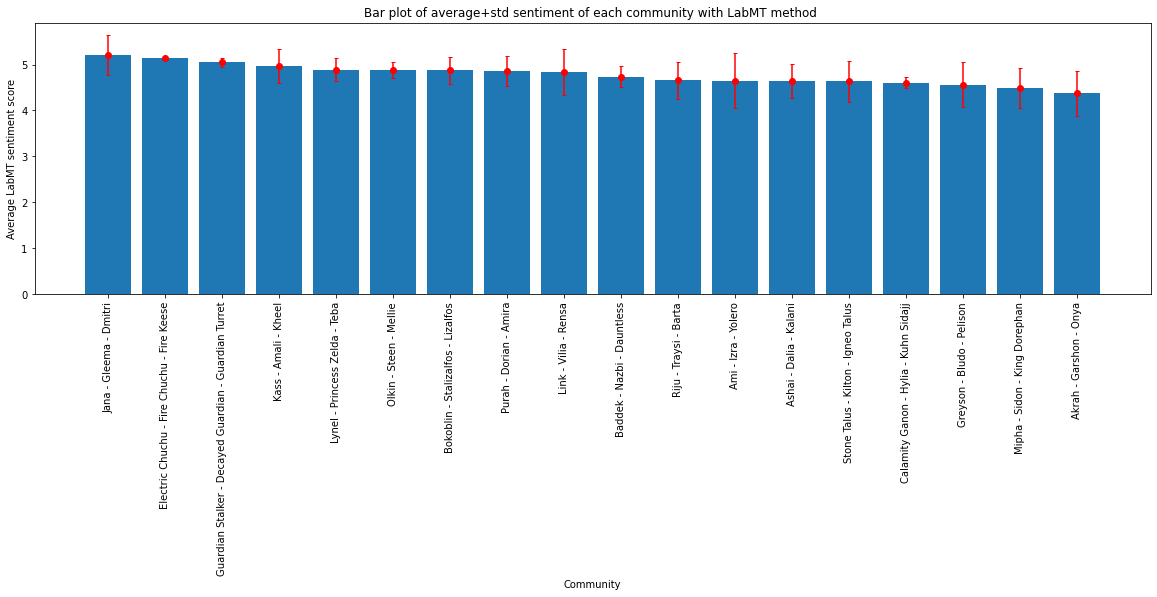

In [77]:
# Creating the plot for LabMT method
communityId_list = [communities_names[anId] for anId in list(df_stats_communities_LabMT.index)]
plt.figure(figsize=(20,5))
plt.bar(communityId_list,df_stats_communities_LabMT['mean'].tolist())
plt.xticks(communityId_list, rotation=90)
plt.title('Bar plot of average+std sentiment of each community with LabMT method ')
plt.xlabel('Community')
plt.ylabel('Average LabMT sentiment score')
plt.errorbar(communityId_list,df_stats_communities_LabMT['mean'].tolist(), yerr = df_stats_communities_LabMT['std'].tolist(), xerr=None, capsize = 2, fmt = 'ro', label = 'standard deviation')
plt.show()

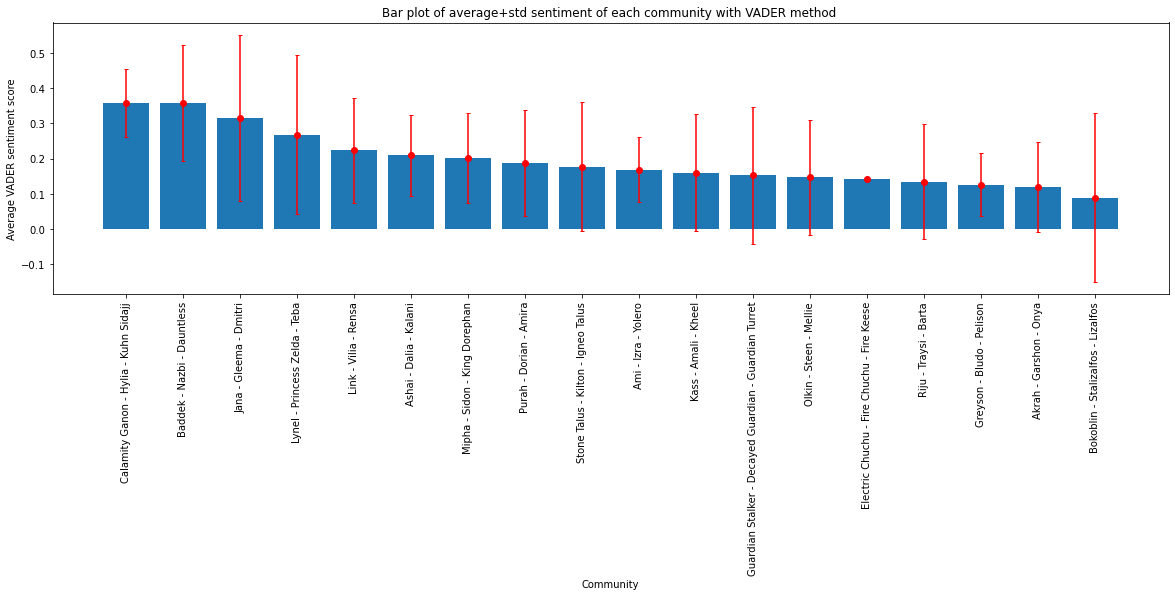

In [78]:
# Creating the plot for LabMT method
communityId_list = [communities_names[anId] for anId in list(df_stats_communities_VADER.index)]
plt.figure(figsize=(20,5))
plt.bar(communityId_list,df_stats_communities_VADER['mean'].tolist())
plt.xticks(communityId_list, rotation=90)
plt.title('Bar plot of average+std sentiment of each community with VADER method ')
plt.xlabel('Community')
plt.ylabel('Average VADER sentiment score')
plt.errorbar(communityId_list,df_stats_communities_VADER['mean'].tolist(), yerr = df_stats_communities_VADER['std'].tolist(), xerr=None, capsize = 2, fmt = 'ro', label = 'standard deviation')
plt.show()

> * Explain the difference between the two methods and compare the results you have obtained above.
> * What is the advantage of using a rule-based method over the dictionary-based approach? 

**TO ANSWER !!!!**

## THE END